<h1 style="text-align: center">Happiness Prediction</h1>

In [82]:
from cmdstanpy import CmdStanModel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

pd.reset_option("display.max_columns")
pd.reset_option("display.max_rows")

## Data R&D

In [83]:
df_main = pd.read_csv('Somerville_happiness_v2.csv', sep=',', header=0)
df_main.info()

def check_relation(array1, array2):
    df_temp = pd.concat([pd.DataFrame(array1), pd.DataFrame(array2)], keys=['array1', 'array2'], axis=1)

    print(df_temp.corr())

    plt.figure()
    plt.imshow(df_temp.corr(), cmap='autumn', interpolation='nearest')
    plt.colorbar()
    plt.xlabel('array1')
    plt.ylabel('array2')
    plt.title('Heat mapp')
    plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Life satisfaction              1049 non-null   int64  
 1   Neighborhood satisfaction      1049 non-null   int64  
 2   Housing satisfaction           1049 non-null   int64  
 3   Community events availability  1049 non-null   int64  
 4   Sense of security              1049 non-null   int64  
 5   Annual household income        1049 non-null   float64
 6   Gender                         1049 non-null   object 
 7   Age                            1049 non-null   object 
 8   Living with children under 18  1049 non-null   int64  
 9   Is disabled                    1049 non-null   int64  
dtypes: float64(1), int64(7), object(2)
memory usage: 82.1+ KB


In [84]:
N = 1000
df_trimed = df_main.head(N)

# All database columns
life_satisfaction = df_trimed['Life satisfaction'].to_numpy()
neighborhood_satisfaction = df_trimed['Neighborhood satisfaction'].to_numpy()
housing_satisfaction = df_trimed['Housing satisfaction'].to_numpy()
community_events_availability = df_trimed['Community events availability'].to_numpy()
sense_of_security = df_trimed['Sense of security'].to_numpy()
annual_household_income = df_trimed['Annual household income'].to_numpy()
gender = df_trimed['Gender'].to_numpy()
age = df_trimed['Age'].to_numpy()
living_with_children = df_trimed['Living with children under 18'].to_numpy()
is_disabled = df_trimed['Is disabled'].to_numpy()

# Normalization
annual_household_income = (annual_household_income/annual_household_income.std(axis=0))
annual_household_income = annual_household_income-annual_household_income.mean(axis=0)

## Prior predictive checks

In [85]:
m1_ppc = CmdStanModel(stan_file='model1_ppc.stan')

rng_num = np.random.randint(low=0, high=100)

d = {'K' : 10,
     'y' : life_satisfaction[rng_num],
     'neigh_sat' : neighborhood_satisfaction[rng_num],
     'hous_sat' : housing_satisfaction[rng_num],
     'com_even_avail' : community_events_availability[rng_num],
     'sen_of_sec' : sense_of_security[rng_num],
     'ann_hous_inc' : annual_household_income[rng_num],
     'liv_with_child' : living_with_children[rng_num],
     'is_disabled' : is_disabled[rng_num]}

# Compilation of model1_ppc.stan and get 1000 samples
samples = m1_ppc.sample(data=d, fixed_param=True, iter_sampling=1000)

# Creation of pandas dataframe from resulting draws
df_res0 = samples.draws_pd()
display(df_res0)

# # Compute ratio of allergic reactions for each sample
# ratio = df['y'] / df['N']

# predictors = df[['Annual household income', 'Housing satisfaction']].head(100).to_numpy()
# print(df['Housing satisfaction'].unique())
# print(predictors)
# predictors = predictors/predictors.max(axis=0)
# # predictors = predictors-predictors.mean(axis=0)
# target = df['Life satisfaction'].head(100).to_numpy().astype('int')
# print(target)
# print(predictors)
# xd = CmdStanModel(stan_file='test.stan')

# d = {'K' : 10,
#      'N' : 100,
#      'J' : 2,
#      'y' : target,
#      'X' : predictors}

# # Compilation of code_1.stan and get 1000 samples
# samples = xd.sample(data=d, fixed_param=True, iter_sampling=1000, iter_warmup=1000, chains=1)
# print(samples.diagnose())

# # Creation of pandas dataframe from resulting draws
# df_old = samples.draws_pd()
# display(df_old)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing


chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


,lp__,accept_stat__,c[1],c[2],c[3],c[4],c[5],c[6],c[7],c[8],...,coef_sen_of_sec[5],coef_sen_of_sec[6],coef_sen_of_sec[7],coef_sen_of_sec[8],coef_sen_of_sec[9],coef_sen_of_sec[10],coef_ann_hous_inc,coef_liv_with_child,coef_is_disabled,happy
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model fit and evaluation

In [86]:
model1_fit = CmdStanModel(stan_file='test2.stan')

d = {'N' : N,
     'K' : 10,
     'y' : life_satisfaction,
     'neigh_sat' : neighborhood_satisfaction,
     'hous_sat' : housing_satisfaction,
     'com_even_avail' : community_events_availability,
     'sen_of_sec' : sense_of_security,
     'ann_hous_inc' : annual_household_income,
     'liv_with_child' : living_with_children,
     'is_disabled' : is_disabled}

# Compilation of test2.stan and get 1000 samples
samples = model1_fit.sample(data=d, iter_sampling=25, iter_warmup=100, chains=4)
print(samples.diagnose())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▎      | 00:00 Status



chain 1 |██████▋   | 00:15 Iteration:   1 / 125 [  0%]  (Warmup)
chain 1 |██████████| 00:15 Iteration: 100 / 125 [ 80%]  (Warmup)


chain 1 |          | 00:19 Iteration: 101 / 125 [ 80%]  (Sampling)
chain 1 |██████████| 00:19 Sampling completed                     
chain 2 |██████████| 00:19 Sampling completed                     
chain 3 |██████████| 00:19 Sampling completed                     
chain 4 |██████████| 00:19 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.



Processing csv files: /tmp/tmpzfeie_0l/test2-20230709074657_1.csv, /tmp/tmpzfeie_0l/test2-20230709074657_2.csv, /tmp/tmpzfeie_0l/test2-20230709074657_3.csv, /tmp/tmpzfeie_0l/test2-20230709074657_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

The following parameters had split R-hat greater than 1.05:
  happy[7], happy[12], happy[54], happy[55], happy[75], happy[83], happy[89], happy[99], happy[104], happy[155], happy[194], happy[195], happy[221], happy[355], happy[366], happy[395], happy[446], happy[448], happy[456], happy[474], happy[491], happy[520], happy[549], happy[571], happy[602], happy[627], happy[645], happy[673], happy[717], happy[764], happy[765], happy[825], happy[839], happy[871], happy[897], happy[986]
Such high values indicate inco

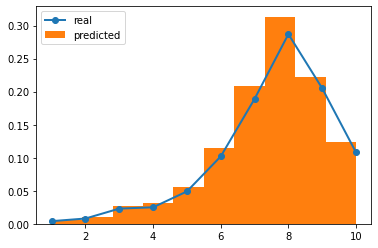

lp__  accept_stat__  stepsize__  treedepth__  n_leapfrog__  \
0  -1827.31       0.941845    0.017413          7.0         127.0   
1  -1831.73       0.993849    0.017413          7.0         255.0   
2  -1842.59       0.597330    0.017413          7.0         255.0   
3  -1842.01       0.983469    0.017413          8.0         255.0   
4  -1841.01       0.969121    0.017413          8.0         255.0   
..      ...            ...         ...          ...           ...   
95 -1825.56       0.983180    0.018994          8.0         255.0   
96 -1829.74       0.928600    0.018994          7.0         127.0   
97 -1836.60       0.997077    0.018994          7.0         255.0   
98 -1831.38       0.998145    0.018994          8.0         255.0   
99 -1828.61       0.751800    0.018994          8.0         255.0   

    divergent__  energy__     c[1]     c[2]      c[3]      c[4]      c[5]  \
0           0.0   1845.40 -4.77725 -3.70599 -2.845260 -2.136020 -1.292410   
1           0.0   1850.15 -4.28884 -2.81332 -1.983580 -1.271640 -0.819397   
2           0.0   1872.52 -2.63044 -2.07033 -0.664256 -0.048957  0.369044   
3           0.0   1864.11 -6.68117 -4.96276 -4.102400 -3.472410 -2.366160   
4           0.0   1868.15 -4.20740 -3.05163 -2.014500 -1.422020 -0.947842   
..          ...       ...      ...      ...       ...       ...       ...   
95          0.0   1848.79 -5.17446 -3.55450 -2.633270 -2.051870 -1.273770   
96          0.0   1848.17 -3.82092 -2.59401 -1.638510 -1.003880 -0.239479   
97          0.0   1861.72 -3.02369 -2.36517 -1.469740 -0.824658 -0.146808   
98          0.0   1855.54 -6.40085 -4.42287 -3.200900 -2.653300 -1.839390   
99          0.0   1855.64 -4.10432 -2.66449 -1.721040 -0.910622 -0.112967   

        c[6]      c[7]     c[8]     c[9]  coef_neigh_sat[1]  \
0  -0.530296  0.442006  1.92332  3.38075          -0.538196   
1   0.033794  1.071350  2.48614  3.89542          -0.557191   
2   1.299240  2.318410  3.70907  5.14846           0.131226   
3  -1.457900 -0.325260  1.03110  2.58215          -0.292027   
4  -0.079538  1.075830  2.47341  4.10596          -1.337720   
..       ...       ...      ...      ...                ...   
95 -0.235529  0.802579  2.31398  3.68623          -1.012850   
96  0.674385  1.710210  3.19644  4.58580          -0.031554   
97  0.809268  1.834170  3.22746  4.55296          -0.360117   
98 -0.900950  0.278891  1.70111  3.08632          -0.484068   
99  0.859684  1.957030  3.44458  4.78070          -0.233842   

    coef_neigh_sat[2]  coef_neigh_sat[3]  coef_neigh_sat[4]  \
0           -0.527108          -0.511417          -0.461448   
1           -0.463195          -0.398979          -0.372501   
2            0.329468           0.334337           0.416981   
3            0.014686           0.016483           0.127492   
4           -1.089590          -1.087780          -0.620949   
..                ...                ...                ...   
95          -0.775728          -0.190882          -0.097071   
96           0.151496           0.271603           0.399176   
97          -0.053413           0.139151           0.199231   
98          -0.368028          -0.006430           0.161837   
99          -0.163106          -0.006186           0.057503   

    coef_neigh_sat[5]  coef_neigh_sat[6]  coef_neigh_sat[7]  \
0           -0.354138          -0.299862          -0.203108   
1           -0.318873          -0.246797          -0.086983   
2            0.431955           0.614075           0.758880   
3            0.149702           0.181594           0.232660   
4           -0.537620          -0.459611          -0.389129   
..                ...                ...                ...   
95          -0.069561           0.028365           0.114354   
96           0.408255           0.434402           0.682326   
97           0.217401           0.230581           0.308507   
98           0.345629           0.386733           0.398560   
99           0.108778           0.233235      

In [87]:
model1_happy = samples.stan_variable('happy').flatten()

plt.figure()
x, y = np.unique(life_satisfaction, return_counts=True)
plt.plot(x, y/sum(y), marker='o', linewidth=2, label='real')
plt.hist(model1_happy, align='mid', density=True, label='predicted')
plt.legend()
plt.show()

pd.set_option('display.max_columns', None) 
# pd.set_option("display.max_rows", None)

df_res = samples.draws_pd()
display(df_res)